In [ ]:
import os


from google.colab import drive
drive.mount('/content/drive')


!ls "/content/drive/MyDrive/newTestData"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
AbnormalMitosis  NormalMitosis


In [ ]:
import os
import numpy as np
from PIL import Image

def load_and_preprocess_data(data_dir, img_size=(128, 128)):
    """Loads images from subdirectories, resizes them, and creates labels."""
    images = []
    labels = []
    for label, class_name in enumerate(os.listdir(data_dir)):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                try:
                    with Image.open(img_path) as img:
                        img = img.resize(img_size)
                        images.append(np.array(img))
                        labels.append(label)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)

# Path to your dataset
data_dir = '/content/drive/MyDrive/newTestData'
images, labels = load_and_preprocess_data(data_dir)

# Print the shape of the arrays to verify
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (24, 128, 128, 3)
Labels shape: (24,)


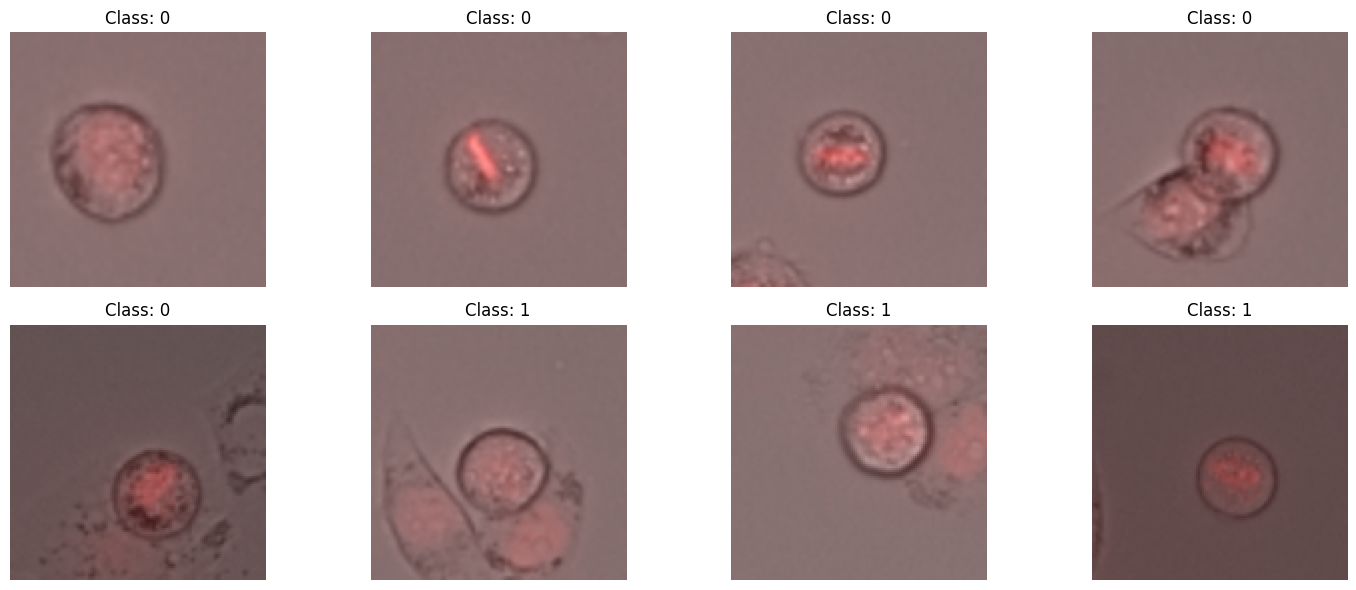

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_and_preprocess_data(data_dir, img_size=(128, 128), max_images_per_class=None):
    """Loads images from subdirectories, resizes them, and creates labels."""
    images = []
    labels = []
    for label, class_name in enumerate(os.listdir(data_dir)):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            image_count = 0
            for filename in os.listdir(class_dir):
                if max_images_per_class and image_count >= max_images_per_class:
                    break
                img_path = os.path.join(class_dir, filename)
                try:
                    with Image.open(img_path) as img:
                        img = img.resize(img_size)
                        images.append(np.array(img))
                        labels.append(label)
                        image_count += 1
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)

# Path to your dataset
data_dir = '/content/drive/MyDrive/newTestData'
images, labels = load_and_preprocess_data(data_dir, max_images_per_class=5)

# Display the first 5 images from each class
num_classes = len(np.unique(labels))
images_per_class = images.shape[0] // num_classes
fig, axes = plt.subplots(num_classes, images_per_class, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(f"Class: {labels[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_30']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)
/tmp/ipython-input-10-2838688370.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")


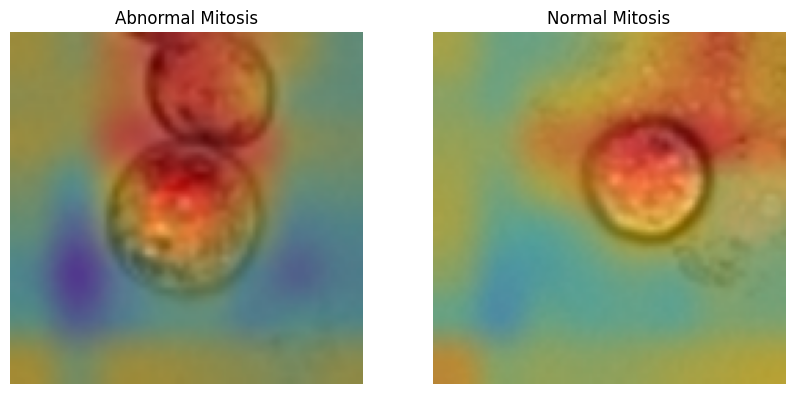

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to display Grad-CAM
def display_gradcam(img, heatmap, alpha=0.4):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Display Grad CAM
    plt.imshow(superimposed_img)
    plt.axis('off')


# --- Visualize Grad-CAM for one normal and one abnormal image ---

# Find the name of the last convolutional layer in our fine-tuned model
last_conv_layer_name = "block5_conv3"

# Find one normal and one abnormal image from the test set
normal_idx = np.where(y_test[:, 1] == 1)[0][0] # Assuming class 1 is Normal
abnormal_idx = np.where(y_test[:, 0] == 1)[0][0] # Assuming class 0 is Abnormal

normal_img_array = X_test[normal_idx]
abnormal_img_array = X_test[abnormal_idx]

# Generate heatmaps
normal_heatmap = make_gradcam_heatmap(np.expand_dims(normal_img_array, axis=0), model, last_conv_layer_name)
abnormal_heatmap = make_gradcam_heatmap(np.expand_dims(abnormal_img_array, axis=0), model, last_conv_layer_name)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Abnormal Mitosis")
display_gradcam(abnormal_img_array * 255, abnormal_heatmap)

plt.subplot(1, 2, 2)
plt.title("Normal Mitosis")
display_gradcam(normal_img_array * 255, normal_heatmap)

plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_30']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)
/tmp/ipython-input-10-2838688370.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")


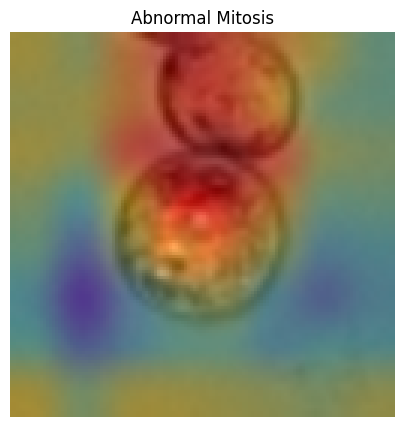

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model


# --- Visualize Grad-CAM for one abnormal image ---

# Find the name of the last convolutional layer in our fine-tuned model
last_conv_layer_name = "block5_conv3"

# Find one abnormal image from the test set
abnormal_idx = np.where(y_test[:, 0] == 1)[0][0] # Assuming class 0 is Abnormal

abnormal_img_array = X_test[abnormal_idx]

# Generate heatmap
abnormal_heatmap = make_gradcam_heatmap(np.expand_dims(abnormal_img_array, axis=0), model, last_conv_layer_name)

# Display the results
plt.figure(figsize=(5, 5))
plt.title("Abnormal Mitosis")
display_gradcam(abnormal_img_array * 255, abnormal_heatmap)
plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the ResNet50 model, pre-trained on ImageNet
# We will not include the top (fully connected) layers
base_model_resnet = ResNet50(weights='imagenet',
                             include_top=False,
                             input_shape=(128, 128, 3))

# Freeze the base model layers
base_model_resnet.trainable = False

# Add a new classifier on top of the base model
# Using GlobalAveragePooling2D is often better than Flatten for ResNet
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
output = Dense(2, activation='softmax')(x) # For our 2 classes

# Create the new model
model_resnet = Model(inputs=base_model_resnet.input, outputs=output)


# For fine-tuning, we can unfreeze some of the later layers of ResNet
# Let's unfreeze from layer 143 onwards
for layer in base_model_resnet.layers[143:]:
    layer.trainable = True


# Compile the model with a low learning rate, which is important for fine-tuning
model_resnet.compile(optimizer=Adam(learning_rate=1e-5),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Display the model summary
model_resnet.summary()


# Train the model using the same generator from before
history_resnet = model_resnet.fit(train_generator,
                                  steps_per_epoch=len(X_train) // 8,
                                  epochs=25,
                                  validation_data=(X_test, y_test))

# Evaluate the new model
loss_resnet, accuracy_resnet = model_resnet.evaluate(X_test, y_test)
print(f"\nTest Accuracy with ResNet50: {accuracy_resnet:.2f}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 15,501,058 (59.13 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.2235 - loss: 0.8677 - val_accuracy: 0.2000 - val_loss: 1.0988
Epoch 2/25
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.8750 - loss: 0.5206

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step - accuracy: 0.8750 - loss: 0.5206 - val_accuracy: 0.2000 - val_loss: 1.0952
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8750 - loss: 0.3941 - val_accuracy: 0.2000 - val_loss: 1.0883
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step - accuracy: 0.6667 - loss: 0.7986 - val_accuracy: 0.2000 - val_loss: 1.0858
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7071 - loss: 0.5627 - val_accuracy: 0.2000 - val_loss: 1.0819
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step - accuracy: 1.0000 - loss: 0.2128 - val_accuracy: 0.2000 - val_loss: 1.0798
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8788 - loss: 0.3343 - val_accuracy: 0.2000 - val_loss: 1.0747
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - accuracy: 0.8750 - loss: 0.4050 - val_accuracy: 0.2000 - val_loss: 1.0721
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8788 - loss: 0.2983 - val_accuracy: 0.2000 - val_loss: 1.0664
Epoch 10/25
2/2

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize the pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')  # 2 classes: normal and abnormal
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4286 - loss: 0.6978 - val_accuracy: 0.5000 - val_loss: 2.4141
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.5714 - loss: 2.8591 - val_accuracy: 0.5000 - val_loss: 0.7867
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.5714 - loss: 0.8447 - val_accuracy: 0.5000 - val_loss: 0.9012
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.4286 - loss: 0.9119 - val_accuracy: 0.5000 - val_loss: 0.8998
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.4286 - loss: 0.9084 - val_accuracy: 0.5000 - val_loss: 0.8190
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.4286 - loss: 0.8166 - val_accuracy: 0.5000 - val_loss: 0.7850
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step - accuracy: 0.4286 - loss: 0.7780 - val_accuracy: 0.5000 - val_loss: 0.7056
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step - accuracy: 0.4286 - loss: 0.6960 - val_accuracy: 0.5000 - val_loss: 0.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Load the VGG16 model, pre-trained on ImageNet
# We will not include the top (fully connected) layers
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(128, 128, 3))

# Freeze the convolutional base
# This prevents the weights of the VGG16 model from being updated during training
conv_base.trainable = False

# Add a new classifier on top of the convolutional base
x = Flatten()(conv_base.output)
x = Dense(256, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# Create the new model
model = Model(conv_base.input, output)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4286 - loss: 0.7437 - val_accuracy: 0.5000 - val_loss: 5.0564
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5714 - loss: 4.1514 - val_accuracy: 0.5000 - val_loss: 2.7016
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5714 - loss: 1.7090 - val_accuracy: 1.0000 - val_loss: 0.4683
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8571 - loss: 0.3736 - val_accuracy: 0.5000 - val_loss: 1.3521
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4286 - loss: 1.3044 - val_accuracy: 0.5000 - val_loss: 0.6965
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5714 - loss: 0.6501 - val_accuracy: 1.0000 - val_loss: 0.3337
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0770 - val_accuracy: 0.5000 - val_loss: 1.1540
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1141 - val_a

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# --- 1. Load ALL available data ---
def load_all_data(data_dir, img_size=(128, 128)):
    """Loads all images from subdirectories, resizes them, and creates labels."""
    images = []
    labels = []
    for label, class_name in enumerate(os.listdir(data_dir)):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                try:
                    with Image.open(img_path) as img:
                        img = img.resize(img_size)
                        images.append(np.array(img))
                        labels.append(label)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)

data_dir = '/content/drive/MyDrive/newTestData'
images, labels = load_all_data(data_dir)
print(f"Loaded {images.shape[0]} total images.")

# --- 2. Split and Preprocess Data ---
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


# --- 3. Data Augmentation ---
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = datagen.flow(X_train, y_train, batch_size=8)


# --- 4. Fine-Tune VGG16 Model ---
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(128, 128, 3))

# Unfreeze the last convolutional block (block5)
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

# Add a new classifier
x = Flatten()(conv_base.output)
x = Dense(256, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

model = Model(conv_base.input, output)

# Compile with a very low learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using the generator
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // 8,
                    epochs=25,  # Increased epochs for fine-tuning
                    validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy after Fine-Tuning: {accuracy:.2f}")

Loaded 24 total images.
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.6932 - loss: 0.6372 - val_accuracy: 0.8000 - val_loss: 0.5852
Epoch 2/25
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.8750 - loss: 0.4602

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 902ms/step - accuracy: 0.8750 - loss: 0.4602 - val_accuracy: 0.8000 - val_loss: 0.5575
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.8788 - loss: 0.3833 - val_accuracy: 0.8000 - val_loss: 0.5475
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.8750 - loss: 0.4022 - val_accuracy: 0.8000 - val_loss: 0.5564
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8977 - loss: 0.3561 - val_accuracy: 0.8000 - val_loss: 0.5822
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 909ms/step - accuracy: 0.7500 - loss: 0.5480 - val_accuracy: 0.8000 - val_loss: 0.5958
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.7917 - loss: 0.4812 - val_accuracy: 0.8000 - val_loss: 0.6170
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 1.0000 - loss: 0.0852 - val_accuracy: 0.8000 - val_loss: 0.6306
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.8283 - loss: 0.5006 - val_accuracy: 0.8000 - val_loss: 0.6432
Epoch 10/25
2/2 ━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


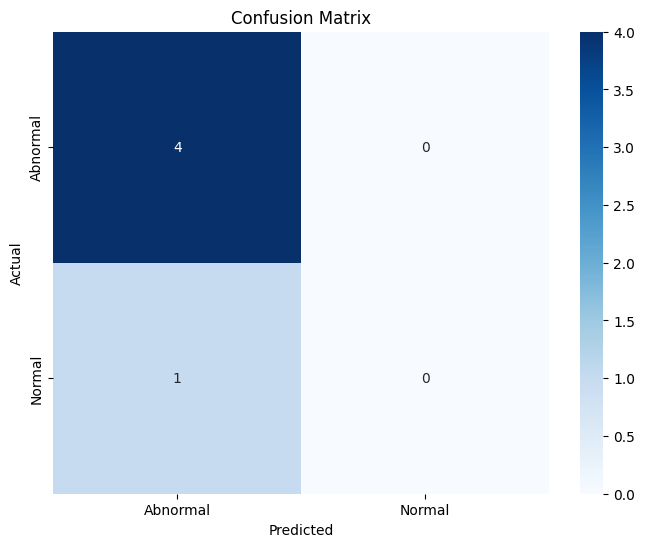


Classification Report:
              precision    recall  f1-score   support

    Abnormal       0.80      1.00      0.89         4
      Normal       0.00      0.00      0.00         1

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get the model's predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Abnormal', 'Normal'], yticklabels=['Abnormal', 'Normal'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['Abnormal', 'Normal']))